In [1]:
import numpy as np,os,sys,glob
import matplotlib.pylab as plt
from ioMicro import *

In [2]:
data_flds = np.array(glob.glob(r'T:\Lab\MERFISH_Imaging_data\06_18_2023_RzA3A6_1_hemi\H*'))

In [3]:
data_flds

array(['T:\\Lab\\MERFISH_Imaging_data\\06_18_2023_RzA3A6_1_hemi\\H1',
       'T:\\Lab\\MERFISH_Imaging_data\\06_18_2023_RzA3A6_1_hemi\\H2',
       'T:\\Lab\\MERFISH_Imaging_data\\06_18_2023_RzA3A6_1_hemi\\H3',
       'T:\\Lab\\MERFISH_Imaging_data\\06_18_2023_RzA3A6_1_hemi\\H4',
       'T:\\Lab\\MERFISH_Imaging_data\\06_18_2023_RzA3A6_1_hemi\\H5',
       'T:\\Lab\\MERFISH_Imaging_data\\06_18_2023_RzA3A6_1_hemi\\H6',
       'T:\\Lab\\MERFISH_Imaging_data\\06_18_2023_RzA3A6_1_hemi\\H7',
       'T:\\Lab\\MERFISH_Imaging_data\\06_18_2023_RzA3A6_1_hemi\\H8',
       'T:\\Lab\\MERFISH_Imaging_data\\06_18_2023_RzA3A6_1_hemi\\H9'],
      dtype='<U55')

In [8]:
resc = 4
icol = -1
fr = 20
data_fld = data_flds[-2]
fls_ = np.sort(glob.glob(data_fld+r'\*.zarr'))
ims,xs_um,ys_um=[],[],[]
from tqdm.notebook import tqdm

for fl in tqdm(fls_[:20]):
    im,x,y = read_im(fl,return_pos=True)
    ims.append(np.array(im[icol][fr,::resc,::resc],dtype=np.float32))
    xs_um.append(x)
    ys_um.append(y)

# im_big,xs,ys = compose_mosaic_ver2([im.T[::-1,::1] for im in ims[:100]],xs_um,ys_um,ims_c=None,
#                               um_per_pix=0.1083333*resc,
#                               rot = 0,return_coords= True)


  0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
def compose_mosaic_ver2(ims,xs_um,ys_um,ims_c=None,um_per_pix=0.108333,rot = 0,return_coords=False):
    dtype = np.float32
    im_ = ims[0]
    szs = im_.shape
    sx,sy = szs[-2],szs[-1]
    ### Apply rotation:
    theta=-np.deg2rad(rot)
    xs_um_ = np.array(xs_um)*np.cos(theta)-np.array(ys_um)*np.sin(theta)
    ys_um_ = np.array(ys_um)*np.cos(theta)+np.array(xs_um)*np.sin(theta)
    ### Calculate per pixel
    xs_pix = np.array(xs_um_)/um_per_pix
    xs_pix = np.array(xs_pix-np.min(xs_pix),dtype=int)
    ys_pix = np.array(ys_um_)/um_per_pix
    ys_pix = np.array(ys_pix-np.min(ys_pix),dtype=int)
    sx_big = np.max(xs_pix)+ sx + 1 
    sy_big = np.max(ys_pix)+sy +1 
    dim = [sy_big,sx_big] # changed
    if len(szs)==3:
        dim = [szs[0],sx_big,sy_big]

    if ims_c is None:
        if len(ims)>25:
            try:
                ims_c = linear_flat_correction(ims,fl=None,reshape=False,resample=1,vec=[0.1,0.15,0.25,0.5,0.65,0.75,0.9])
            except:
                imc_c = np.median(ims,axis=0)
        else:
            ims_c = np.median(ims,axis=0)

    im_big = np.zeros(dim,dtype = dtype)
    sh_ = np.nan
    for i,(im_,x_,y_) in enumerate(zip(ims,xs_pix,ys_pix)):
        if ims_c is not None:
            if len(ims_c)==2:
                im_coef,im_inters = np.array(ims_c,dtype = 'float32')
                im__=(np.array(im_,dtype = 'float32')-im_inters)/im_coef
            else:
                ims_c_ = np.array(ims_c,dtype = 'float32')
                im__=np.array(im_,dtype = 'float32')/ims_c_*np.median(ims_c_)
        else:
            im__=np.array(im_,dtype = 'float32')
        im__ = np.array(im__,dtype = dtype)
        im_big[...,y_:y_+sx ,x_ :x_+ sy]=im__
        sh_ = im__.shape
    if return_coords:
        return im_big,xs_pix+sh_[-2]/2,ys_pix+sh_[-1]/2
    return im_big    

In [11]:
im_big,xs,ys = compose_mosaic_ver2(ims,xs_um,ys_um,ims_c=None,
                              um_per_pix=0.1083333*resc,
                              rot = 0,return_coords= True)

In [12]:
import napari

napari.view_image(im_big,contrast_limits=[0,20000])

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 3433.5, 3433.5), zoom=0.08257862550960977, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1, 1), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 6868.0, 1.0), (0.0, 6868.0, 1.0)), current_step=(3434, 3434), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'im_big' at 0x1cd67d5f550>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, show_vertices=False, selection_box_drag=None, s

Cannot find steve


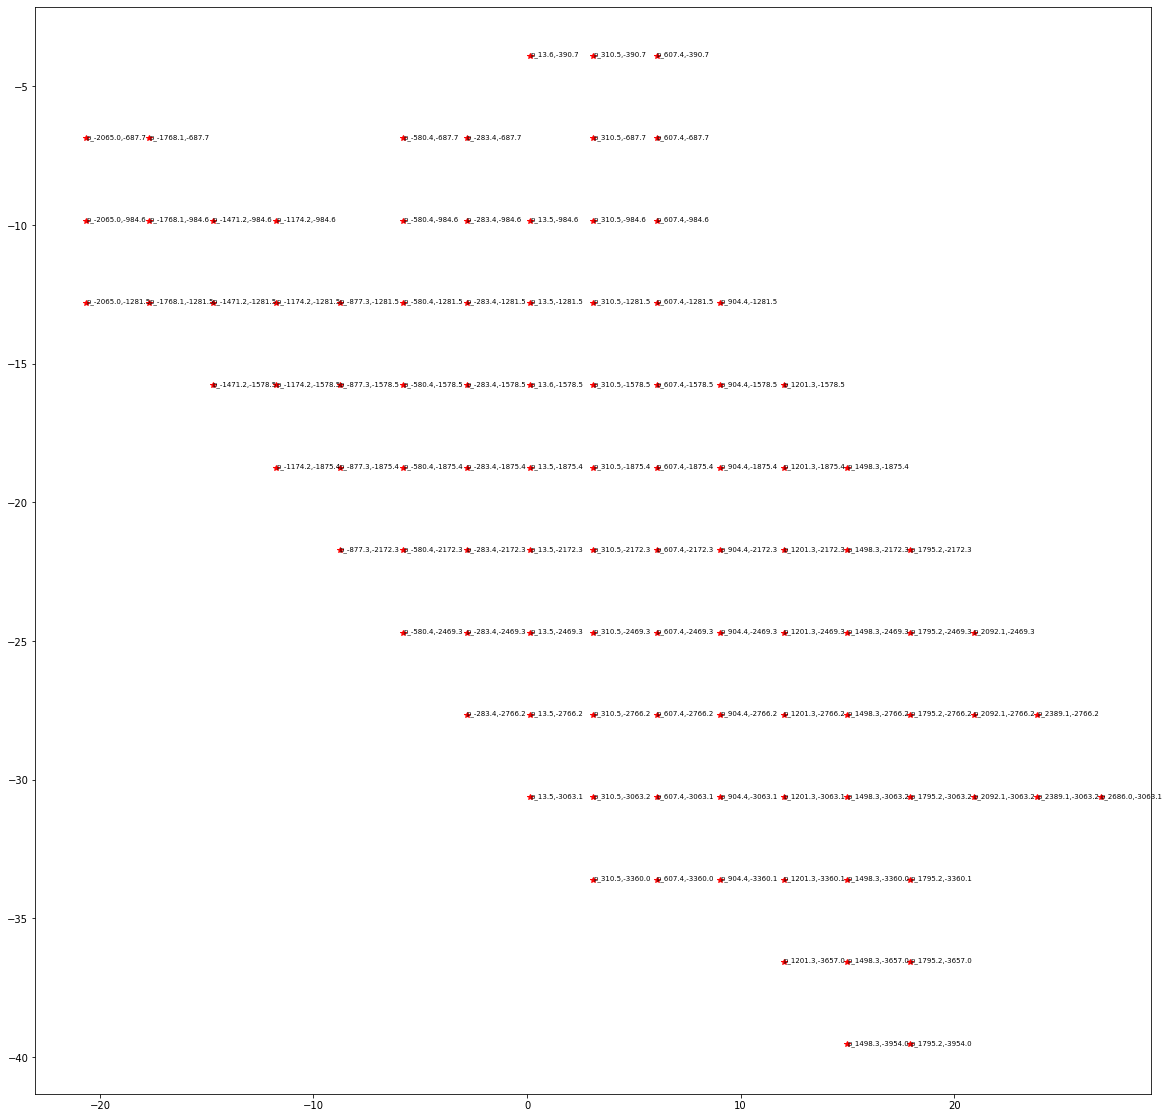

In [49]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,20))
for i,(xs_,ys_) in enumerate(zip(xs_um,ys_um)):
    
    plt.plot(xs_/100,ys_/100,'*',color = 'red')
    plt.text(xs_/100,ys_/100,f'p_{xs_},{ys_}',fontsize = 7)
plt.show()

In [ ]:


data_flds
import time
if True:
    import numpy as np,os,sys,glob
    import matplotlib.pylab as plt
    from ioMicroScope3 import *
    vmax=None
    #data_flds = glob.glob(r'V:\DCBBL1_spinal_01_25_2023\H*')
    for data_fld in data_flds[:]:
        resc = 4
        icol = 1
        fr = 0
        for icol in [3]:
            for fr in [20]:
                if os.path.isdir(data_fld) or True:
                    save_fld = os.path.dirname(data_fld)+os.sep+'mosaics'
                    if not os.path.exists(save_fld): os.makedirs(save_fld)

                    fl_save = save_fld+os.sep+os.path.basename(data_fld)+'_col'+str(icol)+'_fr'+str(fr)+'.png'
                    print(fl_save)
                    if not os.path.exists(fl_save):
                        fls_ = np.sort(glob.glob(data_fld+r'\*.zarr'))
                        ims,xs_um,ys_um=[],[],[]
                        from tqdm.notebook import tqdm

                        for fl in tqdm(fls_[:]):
                            im,x,y = read_im(fl,return_pos=True)
                            ims.append(np.array(im[icol][fr,::resc,::resc],dtype=np.float32))
                            xs_um.append(x)
                            ys_um.append(y)

                        im_big,xs,ys = compose_mosaic([im.T[::-1,::1] for im in ims],xs_um,ys_um,ims_c=None,
                                                      um_per_pix=0.1083333*resc,
                                                      rot = 0,return_coords= True)


                        resc_ = 1
                        data_fld = os.path.dirname(fls_[0])
                        fig = plt.figure(figsize=(30,30))
                        im__ = im_big[::resc_,::resc_]
                        #if vmax is None:
                        vmax = np.percentile(im__[im__>0],99.)
                        vmin=np.percentile(im__[im__>0],1.)
                        plt.imshow(im_big.T[::resc_,::resc_],vmin=vmin,vmax=vmax,cmap='gray')
                        fig.savefig(fl_save)
                        for x_,y_,fl_ in zip(xs,ys,fls_):
                            ifov = fl_.split('_')[-1].split('.')[0]
                            plt.text(x_/resc_,y_/resc_,ifov,color='r')
                        plt.xticks([])
                        plt.yticks([])
                        fl_save = fl_save.replace('.png','_annot.png')
                        print(fl_save)
                        fig.savefig(fl_save)
                        plt.close('all')
#     else:
#         time.sleep(300)

In [6]:
import pandas as pd
t = pd.read_csv('D:/Bereket/Merfish_tools/MERlin_test_run/custom_rig_decoding_test/analysis_parameters/positions/RzA3A6_1hemi_pos.csv')

In [9]:
t.iloc[52:53,:]

,Unnamed: 0,0,1
52,52,1201.29,-3063.18
